# Heart Failure Prediction (Explain)

일전에 진행한 heart failure prediction을 수정하고자 하는 프로젝트이다.\
https://www.kaggle.com/ksvmuralidhar/heart-failure-prediction-auc-0-98 를 보고 복기했으며 auc가 0.98에 해당하는 정확한 예측이다.

프로젝트 진행자의 경우 가장 유의미한 변수인 time을 배제하지 않고 진행하여 auc가 높게 나오는것에 영향을 주었을 수 있다. 하지만 time 변수는 death_event와 무관할 수 없는 변수이기에 이를 제거하고 분석하는 것이 타당해보인다. 따라서 프로젝트 진행자의 코드를 복기하되 time 변수를 배제하면서 진행하고자 한다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [2]:
df["DEATH_EVENT"].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

우선 프로젝트 진행자는 알아내고자 하는 y클래스 - 종속변수가 불균형적으로 분포되어 있음을 지적한다. 이 경우 생존이 전체데이터의 약 68%에 해당하므로 어떤 데이터도 학습시키지 않음에도 68%의 정확도를 갖출 수 있다는 의미이며 이에 SMOTE 기법을 도입하여 데이터 불균형 문제를 해결해야 한다고 주장한다.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


- age : 나이
- anaemia : 빈혈증 여부 (0 = 무, 1 = 유)
- creatinine_phosphokinase : 크레아틴키나제 검사 결과
- diabetes : 당뇨병 여부 
- ejection_fraction : 박출계수
- high_blood_pressure : 고혈압 여부
- platelets : 혈소판 수 
- serum_creatinine : 혈중 크레아틴 레벨
- serum_sodium : 혈중 나트륨 레벨
- sex : 성별 (0 = 여성, 1 = 남성)
- smoking : 흡연여부 (0 = 비흡연, 1 = 흡연)
- time : 관찰기간(일)
- DEATH_EVENT: 사망여부 ( 0 = 생존, 1 = 사망)

In [4]:
cat_features = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
num_features = pd.Series(df.columns)
num_features = num_features[~num_features.isin(cat_features)]

### 범주형 변수와 종속변수간의 관계

In [5]:
from scipy.stats import chi2_contingency 

for i in cat_features:
    ct = pd.crosstab(columns=df[i],index=df["DEATH_EVENT"])
    stat, p, dof, expected = chi2_contingency(ct) 
    print(ct)
    print(f"\nH0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & {i.upper()}\nH1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & {i.upper()}")
    print(f"\nP-VALUE: {np.round(p,2)}")
    print("REJECT H0" if p<0.05 else "FAILED TO REJECT H0")

anaemia        0   1
DEATH_EVENT         
0            120  83
1             50  46

H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & ANAEMIA
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & ANAEMIA

P-VALUE: 0.31
FAILED TO REJECT H0
diabetes       0   1
DEATH_EVENT         
0            118  85
1             56  40

H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & DIABETES
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & DIABETES

P-VALUE: 0.93
FAILED TO REJECT H0
high_blood_pressure    0   1
DEATH_EVENT                 
0                    137  66
1                     57  39

H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & HIGH_BLOOD_PRESSURE
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & HIGH_BLOOD_PRESSURE

P-VALUE: 0.21
FAILED TO REJECT H0
sex           0    1
DEATH_EVENT         
0            71  132
1            34   62

H0: THERE IS NO RELATIONSHIP BETWEEN DEATH_EVENT & SEX
H1: THERE IS RELATIONSHIP BETWEEN DEATH_EVENT & SEX

P-VALUE: 0.96
FAILED TO REJECT H0
smoking   

오차제곱합에 관한 확률분포(카이제곱분포)를 통해 두 개의 범주형 변수가 상관관계에 있는지 독립적인지 먼저 확인한다. 

종속 변수와 그 밖의 모든 범주형 변수는 유의미한 상관관계가 없음을 확인할 수 있다.

상관관계가 있다하더라도 다른 변수간 상관관계가 없는. 독립적 관계라는 전제하에 상관관계가 있는 것이 아니기에 잔차플롯과 같이 상관성을 제거한 변수를 통해 확인해야 확실하다고 할 수 있다.

### 수치형 변수와 종속변수와의 관계

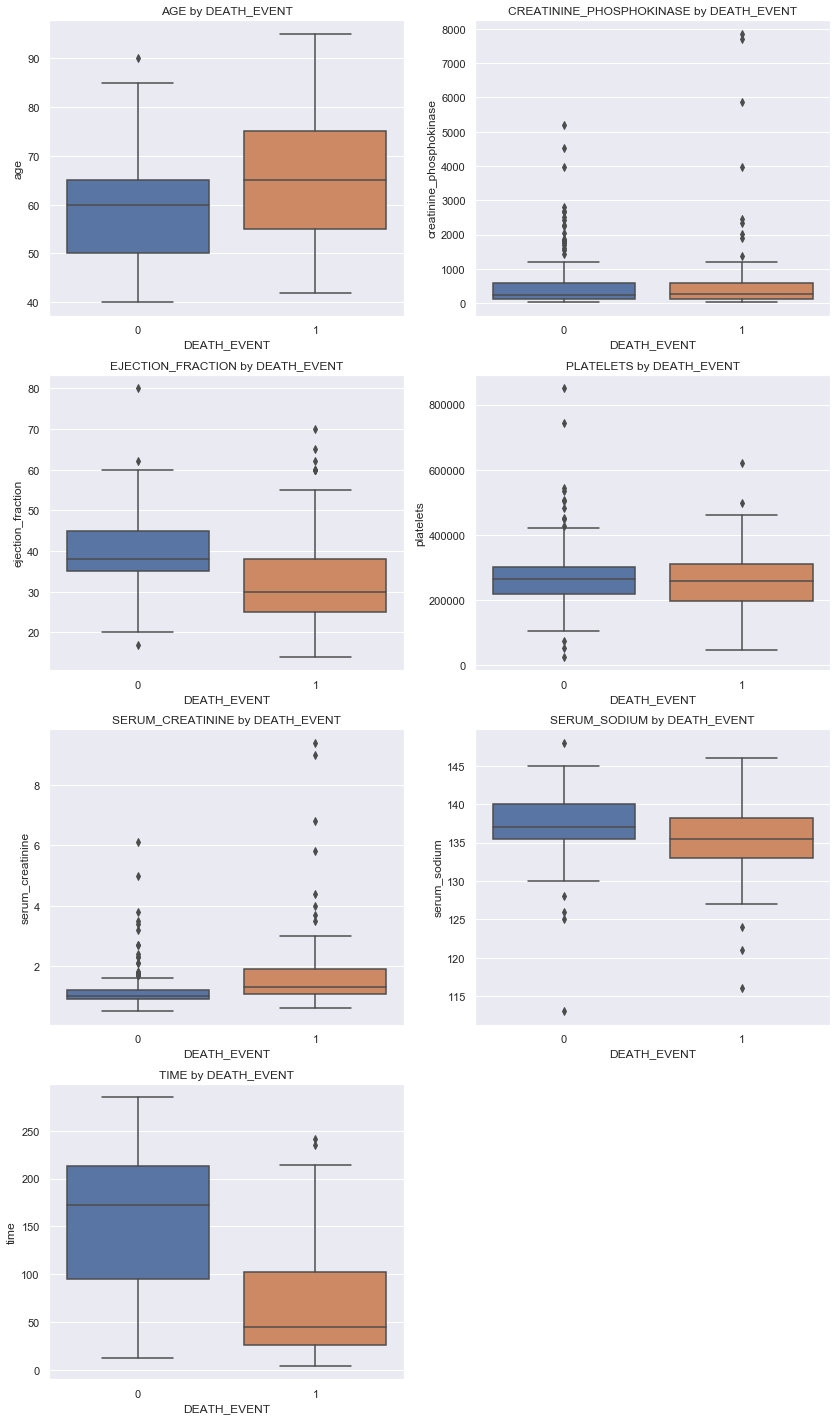

In [6]:
r = c = 0
fig,ax = plt.subplots(4,2,figsize=(14,25))
for n,i in enumerate(num_features):
    sns.boxplot(data=df, x="DEATH_EVENT",y=i,ax=ax[r,c])
    ax[r,c].set_title(i.upper()+" by "+"DEATH_EVENT")
    c+=1
    if (n+1)%2==0:
        r+=1
        c=0
ax[r,c].axis("off")
plt.show()

다음은 Boxplot을 통해 수치형 변수와 타겟변수간의 상관관계를 조명한다.

혼자 진행한 프로젝트에서 표기했듯 time변수의 경우 death_event와 밀접한 관련이 있으므로 제거하는게 적절함.(관찰 도중 death_event 발생시 time도 끝나기때문)

나이-죽음, 박출계수-죽음의 관계가 돋보인다.

### 수치형 변수간의 상관관계

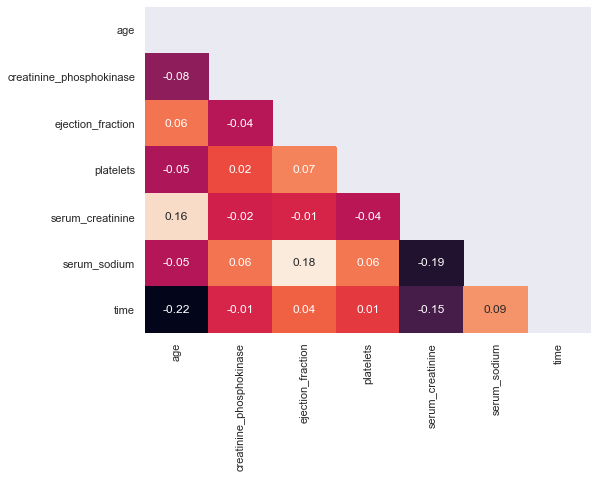

In [7]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(df[num_features].corr(), annot=True, fmt=".2f", mask=np.triu(df[num_features].corr()) ,cbar=False)
plt.show()

수치형 변수간 상관관계를 확인하여 death_event와의 정확한 상관관계를 파악한다. \
상술했듯 서로간 상관관계가 있다면 death_event와의 상관관계에 영향을 미칠 수 있기 때문이다.

다행히 서로간 유의미한 상관관계는 포착되지 않는다.

### 모델 적용 & 변수 중요도 

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

In [9]:
X = df.iloc[:,:-1] # 나머지 변수
y = df.iloc[:,-1] # DEATH_EVENT 변수

model_rf = RandomForestClassifier(n_estimators=5000,random_state=1)
model_rf.fit(X, y)

RandomForestClassifier(n_estimators=5000, random_state=1)

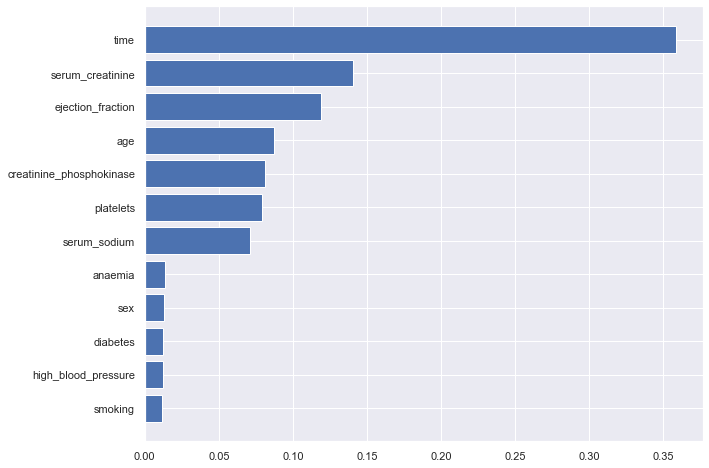

In [10]:
model_coef = pd.DataFrame(data=model_rf.feature_importances_, index=X.columns, columns=['model coefficient'])
model_coef.sort_values(by='model coefficient', inplace=True)
plt.figure(figsize=(10, 8))
plt.barh(model_coef.index, model_coef['model coefficient'])
plt.show()

직관적으로 보기에 나트륨 레벨 까지가 유의미한 변수처럼 보인다. 

모델을 만들어서 모델이 best score가 나오는 변수를 정하도록 설정하는 것이 바람직하다.

프로젝트 진행자는 데이터가 불균형하므로 정확도 보다는 'F1 score'를 사용하는것이 적절하다고 주장한다.

### 모델(time 변수 배제 - default) 적용( SMOTE 기법 없이)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [12]:
X_num = df[['age', 'creatinine_phosphokinase','ejection_fraction', 'platelets',
            'serum_creatinine', 'serum_sodium']]  
        # 수치형 데이터

X_cat = df[['anaemia','diabetes','high_blood_pressure','sex', 'smoking']]
        # 범주형 데이터
    
y = df['DEATH_EVENT']

scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(data=X_scaled, index=X_num.index, columns=X_num.columns)
X = pd.concat([X_scaled, X_cat], axis=1)


model_rf2 = RandomForestClassifier(n_estimators=5000,random_state=1)
model_rf2.fit(X, y)

RandomForestClassifier(n_estimators=5000, random_state=1)

In [13]:
model_coef = pd.DataFrame(data=model_rf2.feature_importances_, index=X.columns, columns=['model coefficient'])
model_coef = (model_coef*100).copy().sort_values(by='model coefficient',ascending=False)
model_coef = model_coef.reset_index()
model_coef.columns=['Feature', 'model coefficient']

In [14]:
model_coef

,Feature,model coefficient
0,serum_creatinine,20.194272
1,ejection_fraction,17.646441
2,age,14.589266
3,creatinine_phosphokinase,12.862215
4,platelets,12.711955
5,serum_sodium,11.337725
6,high_blood_pressure,2.224961
7,diabetes,2.155325
8,anaemia,2.141242
9,sex,2.114747


In [15]:
for var in np.arange(model_coef.shape[0],6,-1):
    X_new = X[model_coef.iloc[:var,0]].copy()
    X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=1)
    final_rf = RandomForestClassifier(random_state=1)
    
    gscv = GridSearchCV(estimator=final_rf,param_grid={
        "n_estimators":[100,500,1000,5000],
        "criterion":["gini","entropy"]
    },cv=5,n_jobs=-1,scoring="f1_weighted")

    gscv.fit(X_train,y_train)
    print(str(var)+" variables:  "+str(gscv.best_estimator_)+"  F1 score: "+str(gscv.best_score_))

11 variables:  RandomForestClassifier(criterion='entropy', random_state=1)  F1 score: 0.7108596088240862
10 variables:  RandomForestClassifier(n_estimators=5000, random_state=1)  F1 score: 0.7093374355446407
9 variables:  RandomForestClassifier(criterion='entropy', random_state=1)  F1 score: 0.7146802759440546
8 variables:  RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=1)  F1 score: 0.713680275892047
7 variables:  RandomForestClassifier(n_estimators=1000, random_state=1)  F1 score: 0.7161808123933208


In [16]:
X_new = X[model_coef.iloc[:7,0]].copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=1)
final_rf = RandomForestClassifier(random_state=11)
gscv = GridSearchCV(estimator=final_rf,param_grid={
    "n_estimators":[100,500,1000,5000],
    "criterion":["gini","entropy"]
},cv=5,n_jobs=-1,scoring="f1_weighted")

gscv.fit(X_train,y_train)
FINAL_MODEL_NO_SMOTE = gscv.best_estimator_

In [17]:
FINAL_MODEL_NO_SMOTE.score(X_test,y_test)

0.7833333333333333

변수를 7개 사용한 모델(유의미한 순으로)이 F1 Score 약 0.716으로 가장 성능이 좋게 나와 최종적으로 변수 7개를 선택.\
하이퍼 파라미터 튜닝을 하지 않은 경우로 랜덤포레스트 경우 max_depth를 정하여 튜닝을 할 수 있고 오버피팅을 방지할 수 있다. \
정확도 78%의 모델

### 모델 (SMOTE 처리하여) 적용

SMOTE : 오버샘플링 일종으로 불균형데이터를 처리하기 위해 소수의 종속변수를 더 생성한다. 더하여 단순 소수데이터만 생성하는 것이 아닌 분류 모형을 적용하여 다수 데이터에 가깝게 위치해있다면 다수 데이터도 생성하는 방법이다.

In [18]:
from imbalanced-learn.over_sampling import SMOTE
from sklearn.decomposition import PCA

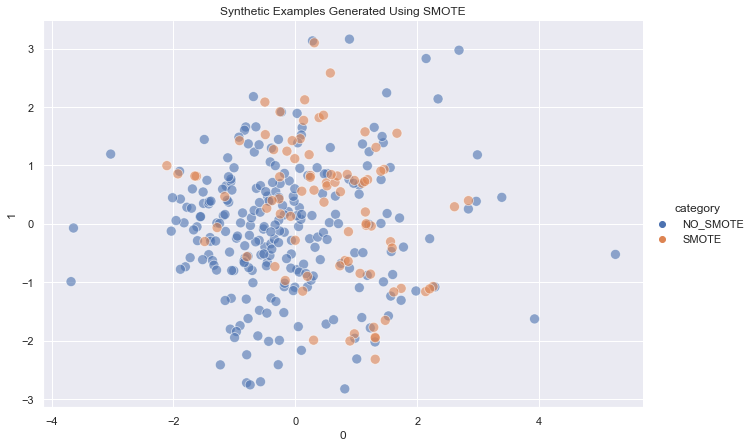

In [34]:
X_new = X.copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=4)
smote = SMOTE(random_state = 4) 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


X_train.insert(11,"category","NO_SMOTE")
X_train_smote.insert(11,"category","SMOTE")


final_X = X_train.append(X_train_smote).copy()
final_X.drop_duplicates(subset=list(final_X.columns[:-1]),inplace=True)
final_cat = final_X["category"]
final_X.drop(columns="category",inplace=True)

pca = PCA(n_components=2)
final_X = pd.DataFrame(pca.fit_transform(final_X))
final_X["category"] = list(final_cat)
final_X = final_X.loc[(final_X[0]<=200000) & (final_X[1]<=2000),:].copy()
sns.relplot(data=final_X, x=0,y=1, hue="category", alpha=0.6, s=100,height=6,aspect=1.5)
plt.title("Synthetic Examples Generated Using SMOTE");

In [35]:
for var in np.arange(model_coef.shape[0],6,-1):
    X_new = X[model_coef.iloc[:var,0]].copy()
    X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=4)
    smote = SMOTE(random_state = 4) 
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    final_rf = RandomForestClassifier(random_state=1)
    
    gscv = GridSearchCV(estimator=final_rf,param_grid={
        "n_estimators":[100,500,1000,5000],
        "criterion":["gini","entropy"]
    },cv=5,n_jobs=-1,scoring="f1_weighted")

    gscv.fit(X_train_smote,y_train_smote)
    print(str(var)+" variables:  "+str(gscv.best_estimator_)+"  F1 score: "+str(gscv.best_score_))

11 variables:  RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=1)  F1 score: 0.8277048870951866
10 variables:  RandomForestClassifier(criterion='entropy', random_state=1)  F1 score: 0.8154089100025722
9 variables:  RandomForestClassifier(n_estimators=5000, random_state=1)  F1 score: 0.799802539948019
8 variables:  RandomForestClassifier(random_state=1)  F1 score: 0.8338305544830916
7 variables:  RandomForestClassifier(random_state=1)  F1 score: 0.8336535168283442


In [37]:
X_new = X[model_coef.iloc[:8,0]].copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=1)
smote = SMOTE(random_state = 4)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
final_rf = RandomForestClassifier(random_state=4)
gscv = GridSearchCV(estimator=final_rf,param_grid={
    "n_estimators":[100,500,1000,5000],
    "criterion":["gini","entropy"]
},cv=5,n_jobs=-1,scoring="f1_weighted")

gscv.fit(X_train_smote ,y_train_smote)
FINAL_MODEL = gscv.best_estimator_

In [38]:
FINAL_MODEL.score(X_test, y_test)

0.8

In [42]:
pred = FINAL_MODEL.predict(X_test)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.90      0.83      0.86        46
           1       0.56      0.71      0.63        14

    accuracy                           0.80        60
   macro avg       0.73      0.77      0.74        60
weighted avg       0.82      0.80      0.81        60



### 모델 심화

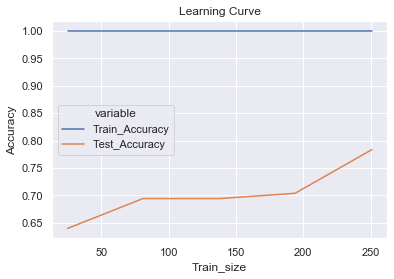

In [44]:
train_size, train_acc, test_acc = learning_curve(FINAL_MODEL, X_train_smote, y_train_smote, cv=5)
learn_df = pd.DataFrame({"Train_size":train_size,"Train_Accuracy":train_acc.mean(axis=1),
                         "Test_Accuracy":test_acc.mean(axis=1)}).melt(id_vars="Train_size")

sns.lineplot(x="Train_size",y="value",data=learn_df,hue="variable")

plt.title("Learning Curve")
plt.ylabel("Accuracy");

당연한 얘기겠지만 training data가 많아질수록 Test accuracy가 올라간다. 지금 데이터 셋의 경우 총 약 300개의 데이터로 split하여 약 240의 train size를 가지는데 부족한 수치이다. 또한 이렇게 train size가 적을경우 오버피팅이 되는 경향이 발생한다.

In [47]:
X_new = X[model_coef.iloc[:8,0]].copy()
X_train, X_test, y_train,y_test = train_test_split(X_new,y,test_size=0.2,random_state=1)
smote = SMOTE(random_state = 4) 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
final_rf = RandomForestClassifier(random_state=4)
gscv2 = GridSearchCV(estimator=final_rf,param_grid={
    "n_estimators":[5000,7000],
    "criterion":["gini","entropy"],
    "max_depth":[3,5,7],
    "min_samples_split":[80,100],
    "min_samples_leaf":[40,50],
},cv=5,n_jobs=-1,scoring="f1_weighted")

gscv2.fit(X_train_smote,y_train_smote)
FINAL_MODEL2 = gscv2.best_estimator_

오버피팅을 방지하기 위해 하이퍼파라미터를 수정하였는데 결과가 더 안좋게 나왔다.\
너무도 적은 데이터를 바탕으로 제일 유의미한 time 변수를 배제하니까 정반대의 결과가 나왔다.\
하이퍼 파라미터 튜닝 경우 n_estimators 를 늘려서 tree를 늘려 오버피팅을 방지하고 max_depth를 설정해주어 더 뻗어나가지 않도록 하여 오버피팅을 방지하였다.

In [50]:
FINAL_MODEL2

RandomForestClassifier(criterion='entropy', max_depth=3, min_samples_leaf=40,
                       min_samples_split=100, n_estimators=5000,
                       random_state=4)

In [51]:
gscv2.best_score_

0.7025567210487011

In [52]:
pred2 = FINAL_MODEL2.predict(X_test)
print(classification_report(y_test,pred2))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        46
           1       0.44      0.57      0.50        14

    accuracy                           0.73        60
   macro avg       0.65      0.68      0.66        60
weighted avg       0.76      0.73      0.74        60



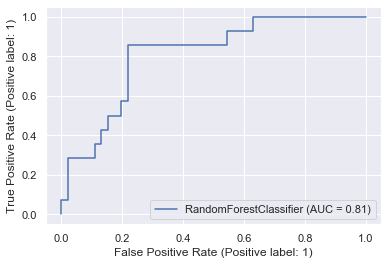

In [53]:
plot_roc_curve(FINAL_MODEL2, X_test, y_test)
plt.show()

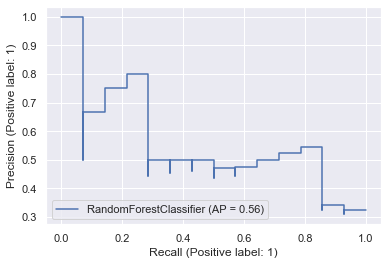

In [54]:
plot_precision_recall_curve(FINAL_MODEL2, X_test, y_test)
plt.show()

결과적으로 SMOTE를 도입하여 오버샘플링 한 것은 도움이 되었으나 하이퍼 파라미터 튜닝의 경우 정반대의 결과가 나왔다.
하이퍼 파라미터의 조건을 더욱 생성해 모델을 더 적용하는 것이 필요할 듯 싶다.